# eTransafe Omeprazole Heatmap

This is the use scenario that has been described in the eTox project for exploring the differences with respect to adverse events between omeprazole preclinical and clinical. In order to compute these results the following scenario is executed:
1. authenticate with the eTransafe keycloak
2. Translate the provided compound (e.g., omeprazole) to a SMILES
3. Retrieve similar compounds based on structural similarity
4. Retrieve data from the preclinical and clinical databases
5. Aggregate the data per system organ class
6. Visualize the data using a heatmap

(C) 2020 Erasmus University Medical Center, Rotterdam, The Netherlands
Author: Erik M. van Mulligen, e.vanmulligen@erasmusmc.nl

In [1]:
import sys  
import knowledgehub
import ipywidgets as w
from IPython.display import display, Markdown, clear_output, Javascript
from ipypublish import nb_setup
import numpy as np
import seaborn as sns
import pandas
import json
import matplotlib.pyplot as plt
import plotly.express as px
from pprint import pprint

In [2]:
api = kh.KnowledgeHubAPI()

# 1. Authentication
Use eTransafe's authentication service to get access to available services

In [3]:
username = w.Text(value='e.vanmulligen@erasmusmc.nl',placeholder='Knowledge Hub account', description='username:', disabled=False)
password = w.Password(value='', placeholder='Knowledge Hub password', description='password:', disabled=False)
loginBtn = w.Button(description='Login')
status = w.Output()

def on_button_clicked(_):
    if api.login(username.value, password.value) == False:
        print("Failed to login")
    else:
        print("successfully logged in")
        display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+2)'))

loginBtn.on_click(on_button_clicked)
w.VBox([username, password, loginBtn])

successfully logged in


<IPython.core.display.Javascript object>

## 2. Translate compound to SMILES using semantic services
For the entered compound name, retrieve the associated SMILES using the semantic services

In [4]:
compoundName = w.Text(value='omeprazole',placeholder='compound name', description='compound:', disabled=False)
compoundBtn = w.Button(description='Retrieve')
compoundSmile = None

def on_compound_entered(_):
        compound = api.SemanticService().normalize(compoundName.value, ['RxNorm','smiles'])
        if 'concepts' in compound:
            for concept in compound['concepts']:
                if 'vocabularyId' in concept:
                    if concept['vocabularyId'] == 'smiles':
                        global compoundSmile
                        compoundSmile = concept['conceptCode']
                        print(f'Found SMILES {compoundSmile} for {compoundName.value}')
                        display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+2)'))

compoundBtn.on_click(on_compound_entered) 
w.VBox([compoundName, compoundBtn])

TypeError: argument of type 'NoneType' is not iterable

Found SMILES COc1ccc2[nH]c(nc2c1)[S+]([O-])Cc3ncc(C)c(OC)c3C for omeprazole


<IPython.core.display.Javascript object>

## 3. Retrieve similar compounds

In [5]:
similar_compounds = api.SimilarityService().get(compoundSmile, nr_results = 20)
compoundIds = []
compoundNames = []
names = []
smiles = []
similarities = []

if similar_compounds != None:
    if ('search_results' in similar_compounds) and (len(similar_compounds['search_results']) == 1):
        search_result = similar_compounds['search_results'][0]
        if 'obj_nam' in search_result:
            for i in range(len(search_result['obj_nam'])):
                names.append(search_result['obj_nam'][i])
                smiles.append(search_result['SMILES'][i])
                similarities.append("{:.4f}".format(search_result['distances'][i]))

            for cmp in search_result['obj_nam']:
                concept = api.SemanticService().normalize(cmp, ['RxNorm'])
                if 'concepts' in concept and len(concept['concepts']) == 1:
                    compoundIds.append(concept['concepts'][0]['conceptCode'])
                    compoundNames.append(concept['concepts'][0]['conceptName'])
        else:
            print('something wrong in the result object from the similarity service')    

pd = nb_setup.setup_pandas(escape_latex=False)
df = pd.DataFrame(np.random.rand(len(names),3),columns=['NAME','SMILES','SIMILARITY'])
df.NAME = names
df.SMILES = smiles
df.SIMILARITY = similarities
df.round(3)

,NAME,SMILES,SIMILARITY
0,Omeprazole,COc1ccc2[nH]c([S+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1,1.0000
1,Esomeprazole,COc1ccc2[nH]c([S@@+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1,0.9990
2,arformoterol,COc1ccc(C[C@@H](C)NC[C@H](O)c2ccc(O)c(NC=O)c2)cc1,0.9886
3,formoterol,COc1ccc(CC(C)NCC(O)c2ccc(O)c(NC=O)c2)cc1,0.9886
4,voriconazole,C[C@@H](c1ncncc1F)[C@](O)(Cn1cncn1)c1ccc(F)cc1F,0.9857
5,idebenone,COC1=C(OC)C(=O)C(CCCCCCCCCCO)=C(C)C1=O,0.9853
6,rabeprazole,COCCCOc1ccnc(C[S+]([O-])c2nc3ccccc3[nH]2)c1C,0.9844
7,alogliptin,Cn1c(=O)cc(N2CCC[C@@H](N)C2)n(Cc2ccccc2C#N)c1=O,0.9844
8,panobinostat,Cc1[nH]c2ccccc2c1CCNCc1ccc(/C=C/C(=O)NO)cc1,0.9836
9,Naltrexone,O=C1CC[C@@]2(O)[C@H]3Cc4ccc(O)c5c4[C@@]2(CCN3C...,0.9835


# 4. Retrieve data from the preclinical and clinical databases

In [6]:
studies = api.Medline().getStudiesByCompoundIds(compoundIds) + \
          api.Faers().getStudiesByCompoundIds(compoundIds) + \
          api.ClinicalTrials().getStudiesByCompoundIds(compoundIds) + \
          api.eToxSys().getStudiesByCompoundNames(compoundNames)
print(f'Found {len(studies)} studies.')

Found 21703 studies.


# 5. Aggregate the data per system organ class

Since the eTox data reports events with an organ. We use our own method to map it to MedDRA's system organ class to make it comparable

In [7]:
system = {}
all_compounds = compoundNames
socs = {}

# traverse all studies and collect the system organ classes; keep track of the # studies per class
for study in studies:
    source = study['source']
    if source != 'eTOXsys' or study['FINDING']['finding'] != 'No abnormalities detected':
        specimenOrgans = api.SemanticService().getSocs(study['FINDING']['specimenOrgan'])
        for specimenOrgan in specimenOrgans:
            if len(specimenOrgan) > 0:
                if not specimenOrgan in socs:
                    socs[specimenOrgan] = 1
                else:
                    socs[specimenOrgan] += 1
                    
# sort the socs per count
all_socs = {k: v for k, v in sorted(socs.items(), key=lambda item: item[1], reverse=True)}

# traverse all studies and create a matrix per source
for study in studies:
    source = study['source']
    if not source in system.keys():
        system[source] = {'data':np.zeros((len(all_socs),len(all_compounds)), dtype=int).tolist(), 
                          'rows':list(all_socs.keys()), 
                          'cols':all_compounds}
    
    if source != 'eTOXsys' or study['FINDING']['finding'] != 'No abnormalities detected':
        specimenOrgans = api.SemanticService().getSocs(study['FINDING']['specimenOrgan'])
        for specimenOrgan in specimenOrgans:
            if len(specimenOrgan) > 0:
                row = system[source]['rows'].index(specimenOrgan)
                col = system[source]['cols'].index(study['COMPOUND']['name'])
                system[source]['data'][row][col] += 1
                

# 6. Visualize the data using a heatmap

Using seaborn to visualize the content of the various databases. Note that we have to think about ways to easier compare the various results.

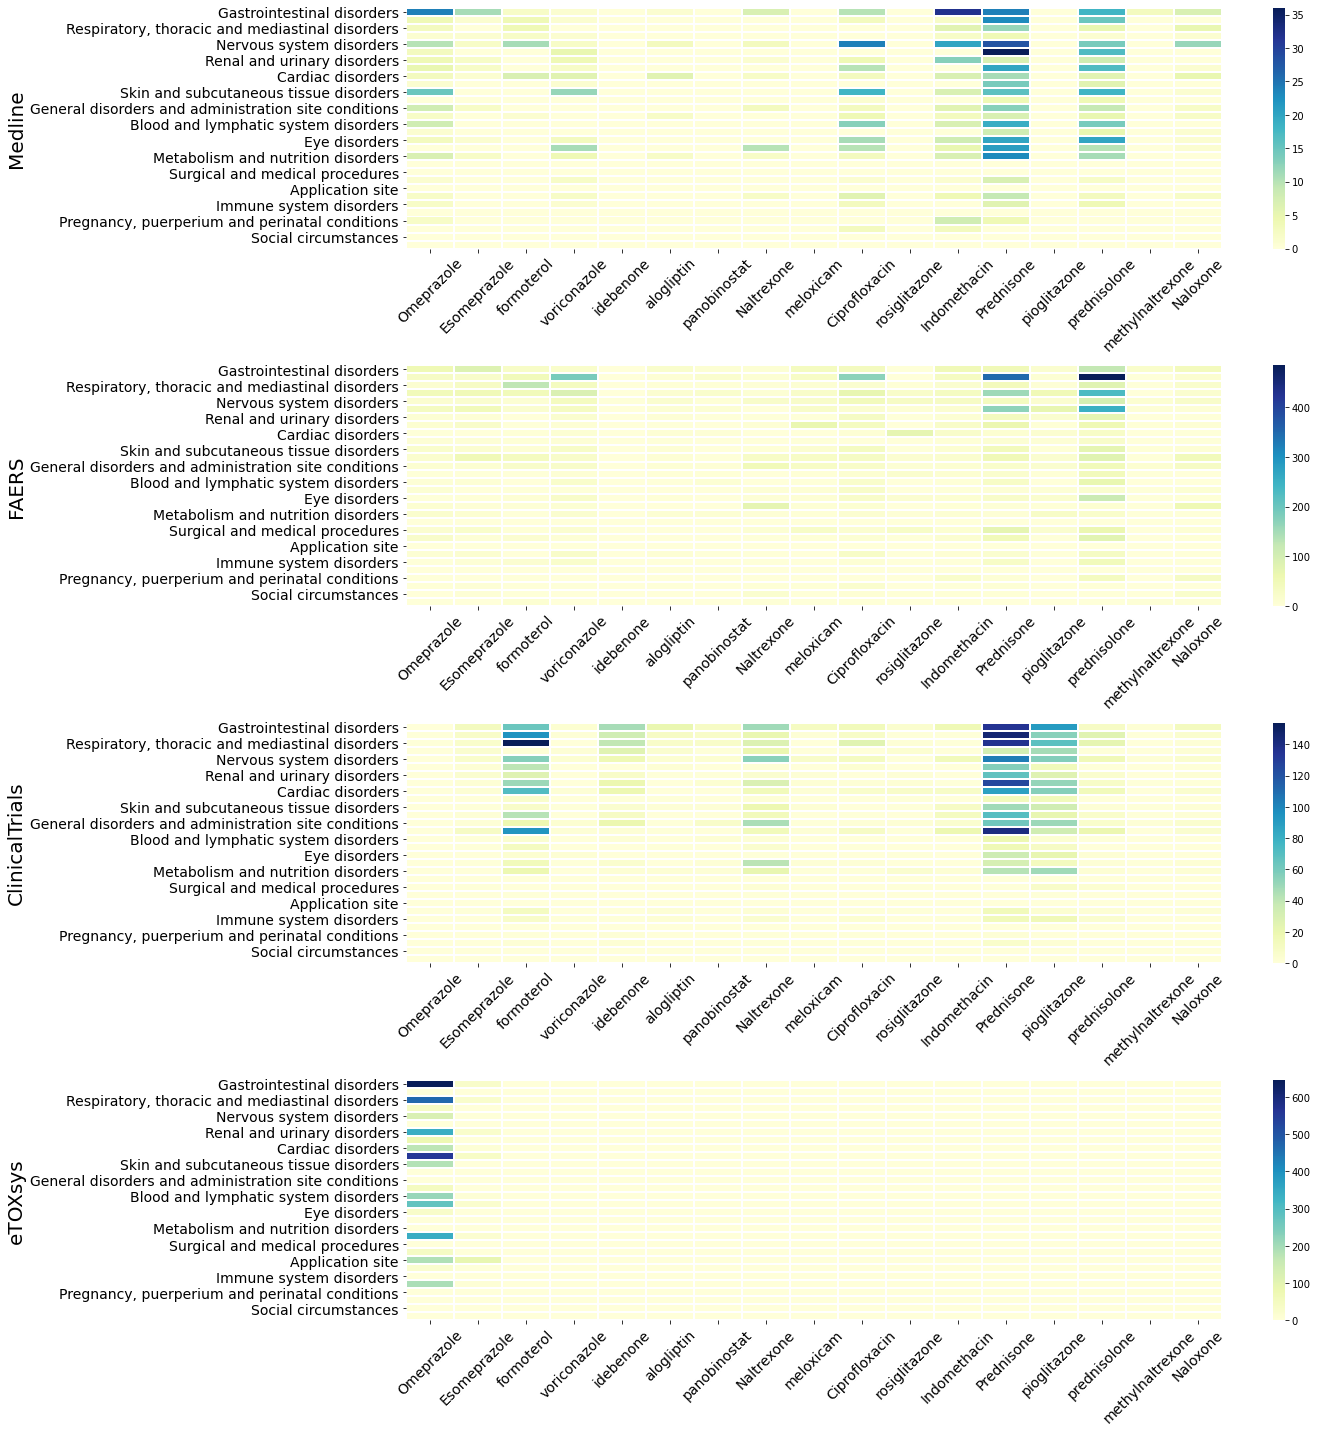

In [8]:
figure, axes = plt.subplots(figsize=(20,20))
i = 1
for source,value in system.items():
    plt.subplot(4, 1, i)
    df = pandas.DataFrame(value['data'], index=value['rows'], columns=value['cols'])
    ax = sns.heatmap(df, linewidths=1.0, cmap="YlGnBu")
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=14, rotation=45)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=14)
    plt.ylabel(source, fontsize=20)
    i += 1

figure.tight_layout()
plt.show()

## make a sunburst

In [ ]:
for source,value in system.items():
    data = dict(character = all_compounds,
               parent = )